In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## for distances
from scipy.spatial.distance import cosine

In [ ]:
# Set pandas formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [ ]:
# Set up wikidata API
!pip -q install qwikidata
!pip -q install sparqlwrapper

from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
import sys
import seaborn as sns
import folium # mapping
from folium.plugins import HeatMap
import missingno as msno
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from typing import List, Dict

import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

Setup Complete


In [ ]:
# modified from https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f
import json
import ast

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.
        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.
        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            print(result)
            break
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    # Function to remove invalid control characters
    def __remove_invalid_chars(text):
        return ''.join(char for char in text if ord(char) > 31 or char == '\n' or char == '\t')

    def _load(self) -> List[Dict]:
      """
      Helper function that loads the data from Wikidata using the SPARQLWrapper library,
      and transforms the results into a list of dictionaries.
      """
      results = self.sparql.queryAndConvert()['results']['bindings']
      return results  # Return directly as Python list


    def load_as_dataframe(self) -> pd.DataFrame:
      """
      Executes the SPARQL query and returns the results as a Pandas DataFrame.
      """
      results = self._load()
      df = pd.DataFrame(results)  # Convert to DataFrame directly

      # Ensure values are extracted properly
      df = df.applymap(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)

      return df


In [ ]:
# Some relations such as wdt:P1081 links to multiple values,
# Fortunately, calling ?country wdt:P1081 ?HDI will automatically return the latest HDI,


countryQuery = """
SELECT DISTINCT ?countryLabel ?lifeExpectancy ?medianIncome ?HDI ?retirementAge ?unemploymentRate
WHERE {

  ?country wdt:P31 wd:Q6256.
  ## YOUR CODE STARTS HERE
  OPTIONAL { ?country wdt:P2250 ?lifeExpectancy. }
  OPTIONAL { ?country wdt:P3529 ?medianIncome. }
  OPTIONAL { ?country wdt:P1081 ?HDI. }
  OPTIONAL { ?country wdt:P3001 ?retirementAge. }
  OPTIONAL { ?country wdt:P1198 ?unemploymentRate. }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

## Output format is given below
Country_df = WikiDataQueryResults(countryQuery).load_as_dataframe()

##  YOUR CODE STARTS HERE
Country_df = WikiDataQueryResults(countryQuery).load_as_dataframe()
Country_df = Country_df.groupby('countryLabel', as_index=False).first()

Country_df

,countryLabel,lifeExpectancy,HDI,unemploymentRate,retirementAge,medianIncome
0,Afghanistan,63.673,0.478,9,None,None
1,Albania,78.345,0.796,16,None,None
2,Algeria,76.078,0.745,10,60,None
3,Andorra,None,0.858,None,None,None
4,Angola,61.547,0.586,7,None,None
...,...,...,...,...,...,...
190,Venezuela,71,0.691,None,60,None
191,Vietnam,76.253,0.703,2,None,None
192,Yemen,64.953,0.455,60,None,None
193,Zambia,61.874,0.565,13,None,None


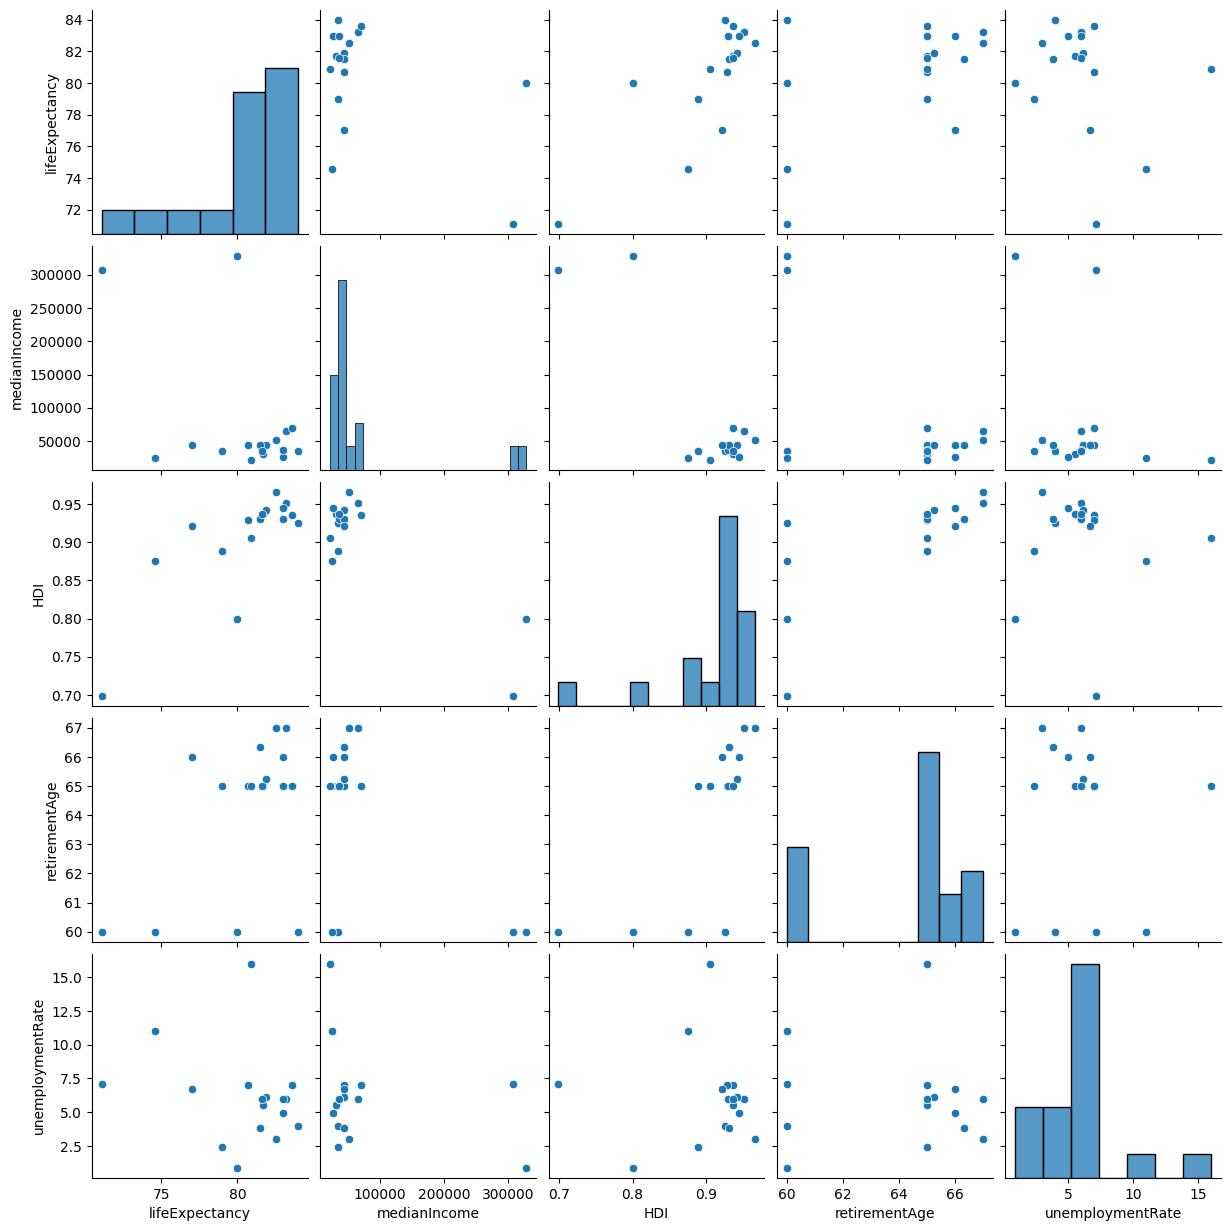

In [ ]:
# get everything to numerical
Country_df=Country_df.drop(columns=['countryLabel'])
Country_df = Country_df.apply(pd.to_numeric)
## YOUR CODE STARTS HERE

num_columns = ["lifeExpectancy", "medianIncome", "HDI", "retirementAge", "unemploymentRate"]
df_numeric = Country_df[num_columns].dropna()
sns.pairplot(df_numeric)
plt.show()


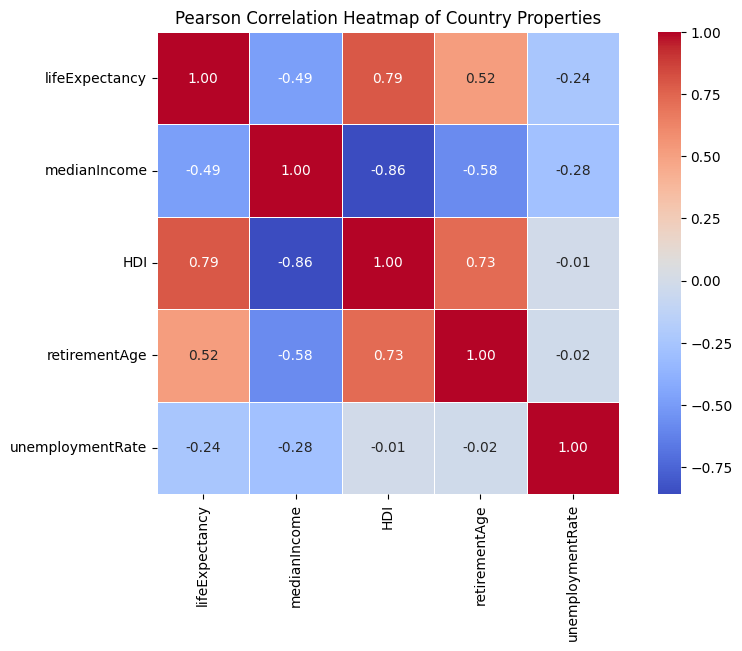

In [ ]:
# Correlation Heatmap
correlation_matrix = df_numeric.corr(method="pearson")
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Pearson Correlation Heatmap of Country Properties")
plt.show()

**Enter answer here:** HDI and Life Expectancy can be seen to have a strong relationship (0.79). This is because HDI is informed by Life Expectancy, among other things.

In [ ]:
actor_genre_Query = """
SELECT DISTINCT ?movieLabel ?actorLabel ?genreLabel ?releaseDate
WHERE {
  ## YOUR CODE STARTS HERE
  ?actor wdt:P166 wd:Q103916.
  ?movie wdt:P161 ?actor.
  ?movie wdt:P166 wd:Q103916.
  ?movie wdt:P136 ?genre.
  ?movie wdt:P577 ?releaseDate.

  FILTER(YEAR(?releaseDate) > 1980)
  FILTER(YEAR(?releaseDate) < 2020)

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en".}
}

limit 20000
"""

## Output format is given below
actor_genre_df = WikiDataQueryResults(actor_genre_Query).load_as_dataframe()
actor_genre_df

,releaseDate,movieLabel,actorLabel,genreLabel
0,1989-02-24T00:00:00Z,My Left Foot,Daniel Day-Lewis,film based on book
1,2012-10-08T00:00:00Z,Lincoln,Daniel Day-Lewis,historical film
2,2013-01-13T00:00:00Z,Lincoln,Daniel Day-Lewis,historical film
3,2013-01-24T00:00:00Z,Lincoln,Daniel Day-Lewis,historical film
4,1982-12-10T00:00:00Z,Gandhi,Daniel Day-Lewis,drama fiction
...,...,...,...,...
767,1984-01-01T00:00:00Z,Amadeus,F. Murray Abraham,period drama film
768,1993-03-04T00:00:00Z,Scent of a Woman,Philip Seymour Hoffman,film based on a novel
769,1984-09-06T00:00:00Z,Amadeus,F. Murray Abraham,period drama film
770,1984-09-12T00:00:00Z,Amadeus,F. Murray Abraham,period drama film


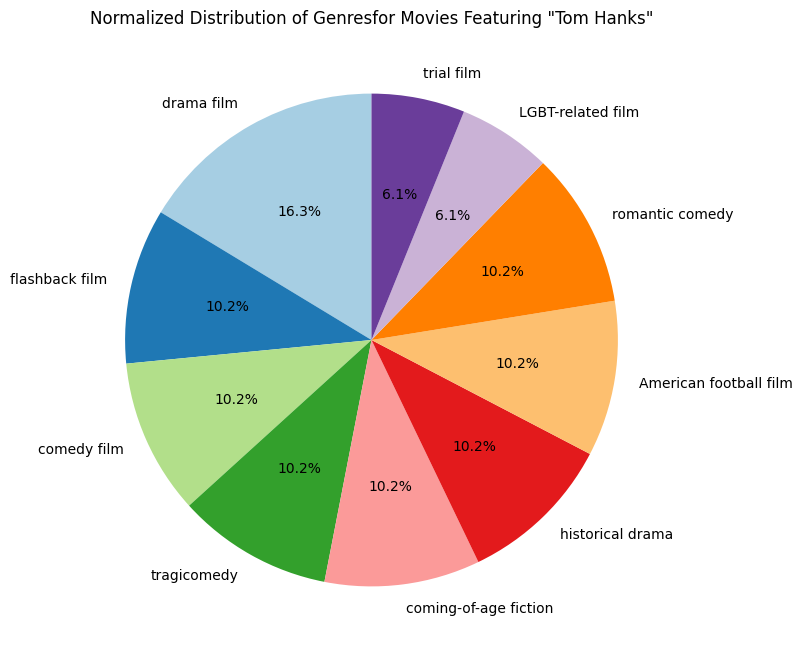

In [ ]:
## YOUR CODE STARTS HERE

actor_genre_crosstab = pd.crosstab(index=actor_genre_df['actorLabel'], columns=actor_genre_df['genreLabel'], values=actor_genre_df['movieLabel'], aggfunc='count', dropna=False)

actor_genre_crosstab = actor_genre_crosstab.sort_index(axis=0).sort_index(axis=1)

tom_hanks_movies = actor_genre_df[actor_genre_df['actorLabel'] == 'Tom Hanks']

genre_distribution = tom_hanks_movies['genreLabel'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
plt.pie(genre_distribution, labels=genre_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Normalized Distribution of Genresfor Movies Featuring "Tom Hanks"')
plt.show()


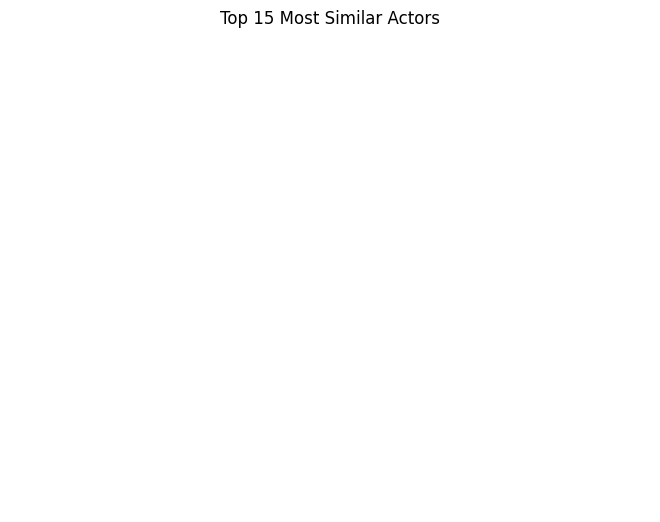

In [ ]:
# Generate a graph of the similarity between the top 15 most similar actors.

# Initialize an empty list to store the results
similarity_results = []

## YOUR CODE STARTS HERE
actor_names = actor_genre_crosstab.index

for i, actor1 in enumerate(actor_names):
    for j, actor2 in enumerate(actor_names):
        if i < j:
            vector1 = actor_genre_crosstab.loc[actor1]
            vector2 = actor_genre_crosstab.loc[actor2]

            similarity_score = 1 - cosine(vector1, vector2)
            similarity_results.append((actor1, actor2, similarity_score))

similarity_results.sort(key=lambda x: x[2], reverse=True)

top_15_similar_actors = similarity_results[:15]


G = nx.Graph()
# hint, similarity_results = [ (actors1, actors2, cosine_similarity_score), ... ]
# Each tuple will represent an edge

# YOUR CODE CONTINUES HERE
for actor1, actor2, similarity_score in top_15_similar_actors:
    G.add_edge(actor1, actor2, weight=similarity_score)

nx.draw(G, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('Top 15 Most Similar Actors')
plt.show()